In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28 images
hidden_sizes = [256, 128, 64, 16]  # Encoder structure
num_epochs = 5
batch_size = 128
learning_rate = 0.001
noise_levels = [0.1, 0.5, 0.8]

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder: 784 -> 256 -> 128 -> 64 -> 16
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(True),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(True),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(True),
            nn.Linear(hidden_sizes[2], hidden_sizes[3])
        )

        # Decoder: 16 -> 64 -> 128 -> 256 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(hidden_sizes[3], hidden_sizes[2]),
            nn.ReLU(True),
            nn.Linear(hidden_sizes[2], hidden_sizes[1]),
            nn.ReLU(True),
            nn.Linear(hidden_sizes[1], hidden_sizes[0]),
            nn.ReLU(True),
            nn.Linear(hidden_sizes[0], input_size),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Initialize model, loss function, and optimizer
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
def add_noise(images, noise_factor):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy_images, 0., 1.)  # Keep values within [0,1]


In [ ]:
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)  # Flatten

        # Add noise
        noise = torch.randn(img.shape, device=device) * noise_levels[1]  # Default noise level 0.5
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0., 1.)

        # Forward pass
        output = model(noisy_img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/5], Loss: 0.0661
Epoch [2/5], Loss: 0.0441
Epoch [3/5], Loss: 0.0340
Epoch [4/5], Loss: 0.0304
Epoch [5/5], Loss: 0.0280


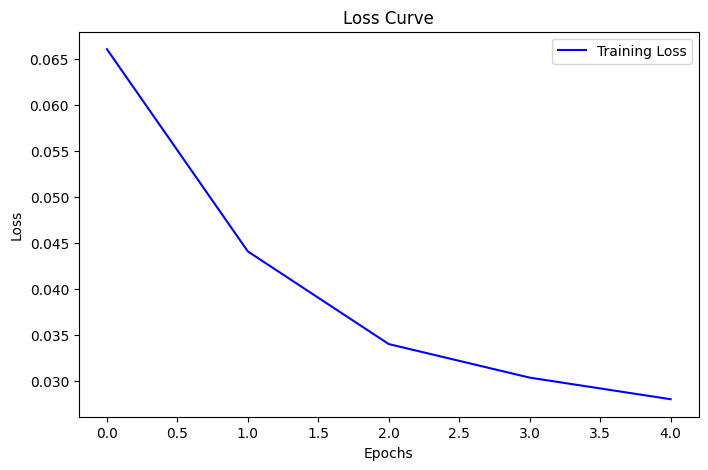

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


In [ ]:
def visualize_with_noise(model, loader, noise_factors):
    model.eval()
    with torch.no_grad():
        dataiter = iter(loader)
        images, _ = next(dataiter)
        images = images.view(images.size(0), -1).to(device)

        plt.figure(figsize=(18, 12))

        for j, noise_factor in enumerate(noise_factors):
            noisy_images = add_noise(images, noise_factor)
            reconstructed = model(noisy_images)

            images_cpu = images.view(-1, 28, 28).cpu().numpy()
            noisy_cpu = noisy_images.view(-1, 28, 28).cpu().numpy()
            recon_cpu = reconstructed.view(-1, 28, 28).cpu().numpy()

            for i in range(5):
                idx = j * 15 + i + 1

                # Original Image
                if j == 0:
                    plt.subplot(len(noise_factors), 15, idx)
                    plt.imshow(images_cpu[i], cmap='gray')
                    plt.axis('off')
                    if i == 2:
                        plt.title("Original")

                # Noisy Image
                plt.subplot(len(noise_factors), 15, idx + 5)
                plt.imshow(noisy_cpu[i], cmap='gray')
                plt.axis('off')
                if i == 2:
                    plt.title(f"Noisy (Factor {noise_factor})")

                # Reconstructed Image
                plt.subplot(len(noise_factors), 15, idx + 10)
                plt.imshow(recon_cpu[i], cmap='gray')
                plt.axis('off')
                if i == 2:
                    plt.title("Reconstructed")

        plt.tight_layout()
        plt.show()


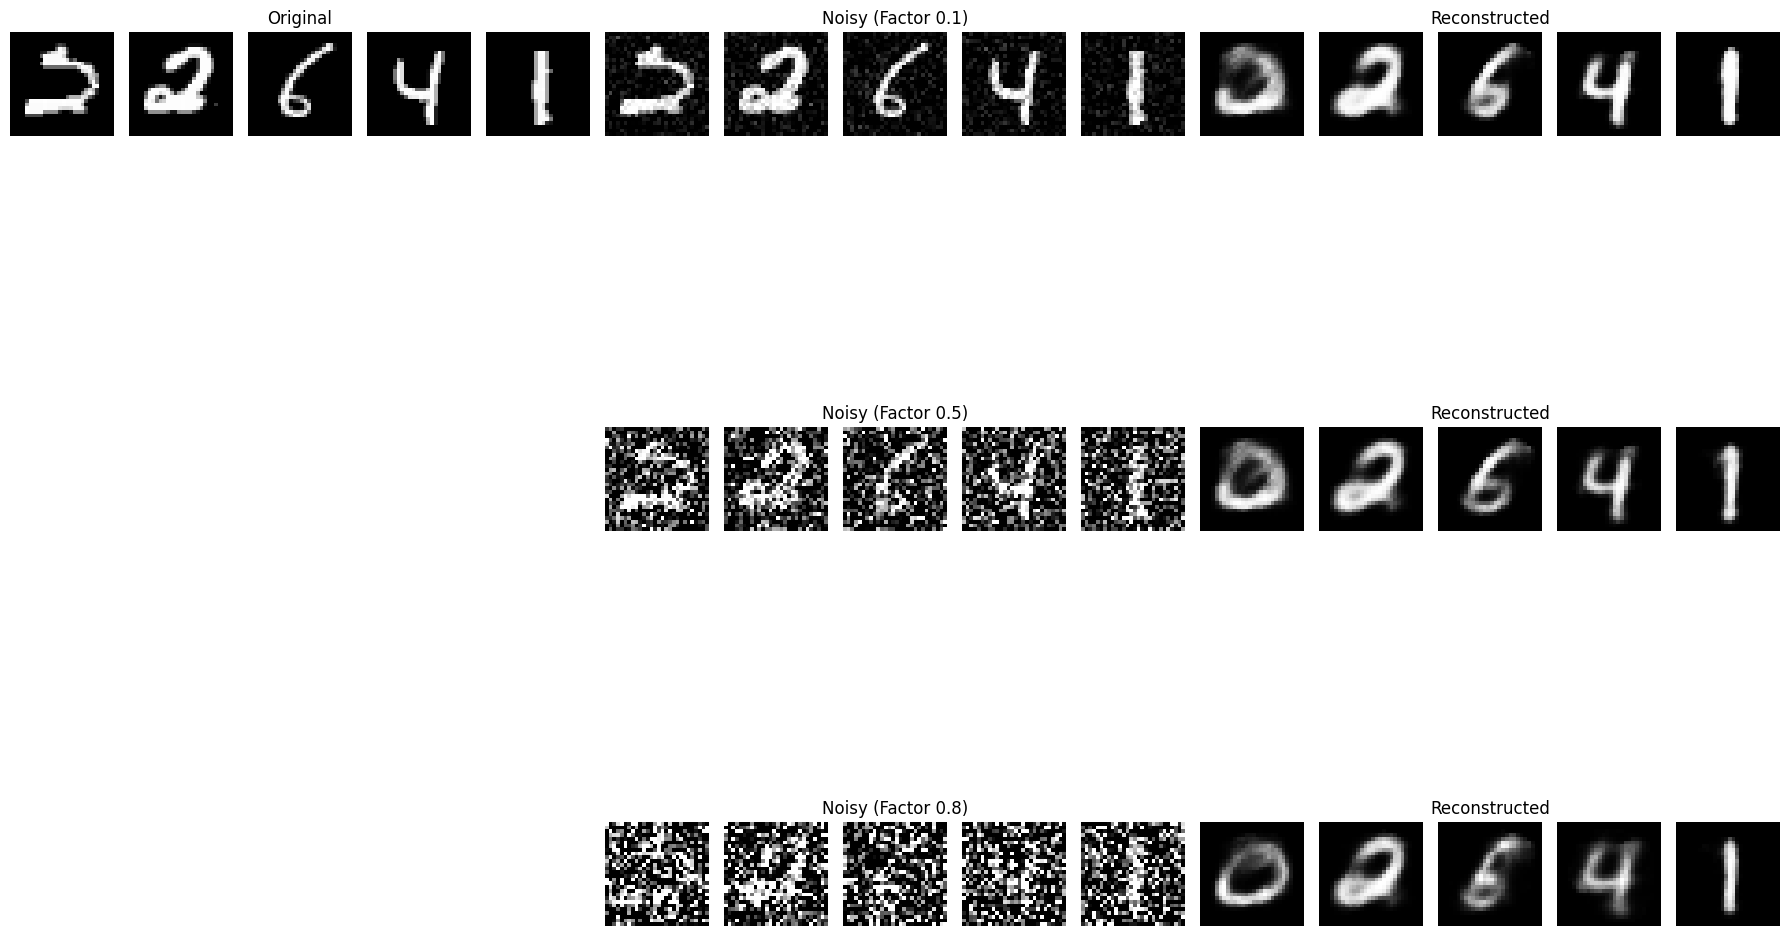

In [ ]:
visualize_with_noise(model, train_loader, noise_levels)
